## Univariate LSTM

# Import packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from pandas_datareader import data as wb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# Input data

[*********************100%%**********************]  1 of 1 completed


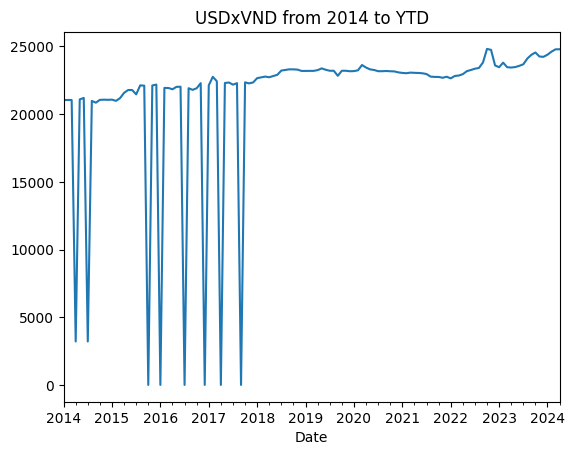

Total data: 10 years


In [3]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31', interval = '1mo')

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2014 to YTD")
plt.show()

# Summary statistics
df = pd.DataFrame(data['Adj Close']) 

diff = df.index.values[-1] - df.index.values[0]
months = diff.astype('timedelta64[M]')
years = int(months/12)
print("Total data: %d years" %years)

In [4]:
dataset = df.values
dataset = dataset.astype('float32')

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# separate into train and test data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

model.save('fundamental_model_eurusd_300epochs.h5')

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)


def inverse_transform(arr):
    extended = np.zeros((len(arr), 1))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]


trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

Epoch 1/300


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6610
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4362 
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2673 
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1259 
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0759 
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 
Epoch 9/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511 
Epoch 10/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 
Epoch 11/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493 
Epoch 12/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0596 
Epoch 13/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0692 
Epoch 14/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350 
Epoch 15/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0637 
Epoch 16/300
6/6 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


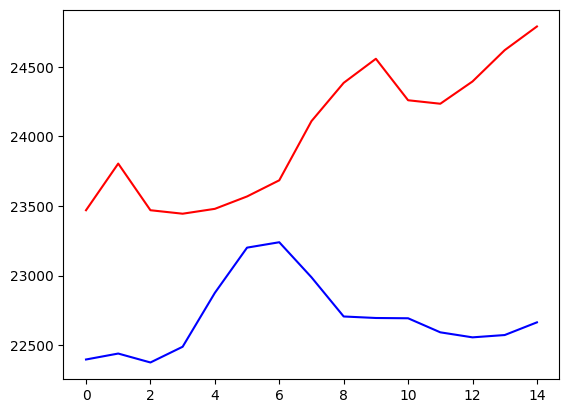

Test Score: 1428.16 RMSE


In [13]:
# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

plt.plot(testPredict, color="blue")
plt.plot(testY, color="red")
plt.show()
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))